In [1]:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import gc
import numpy as np
import matplotlib.pyplot as plt

2024-02-26 08:41:10.034456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 08:41:10.034570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 08:41:10.168119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Configuring GPU settings:

In [2]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# Defining Image sizes

In [3]:
h = 304
w = 304

# Loading dataset

In [4]:
import glob
train = sorted(glob.glob("/kaggle/input/alabama-buildings-segmentation/alabama/image/*"))[:3000]
train_mask = sorted(glob.glob("/kaggle/input/alabama-buildings-segmentation/alabama/mask/*"))[:3000]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 3000
Total Mask Image : 3000


# Converting images into numpy arrays and pre-processing

In [5]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm.notebook import trange, tqdm
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = (mask/255.0)//0.51

0it [00:00, ?it/s]

# Displaying image and masks

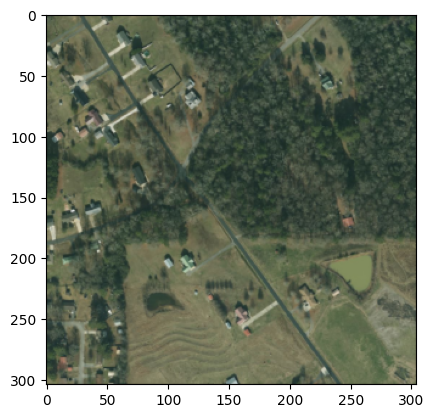

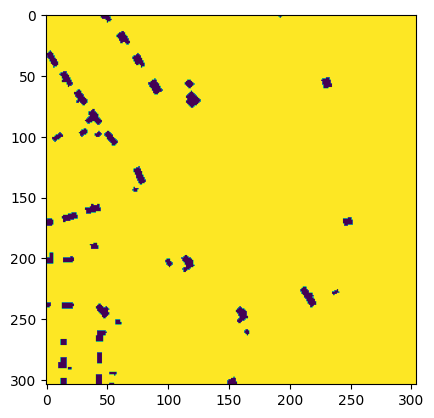

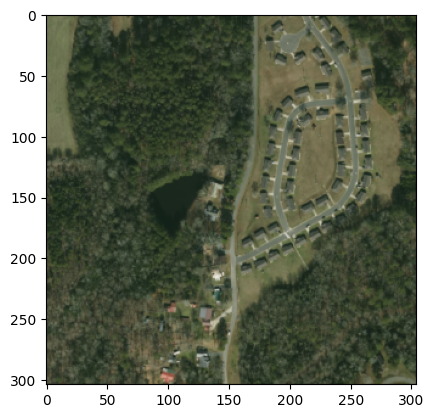

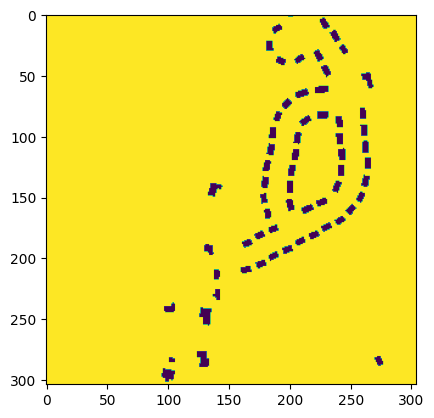

In [8]:
plt.imshow(X[400])
plt.show()
plt.imshow(y[400])
plt.show()
plt.imshow(X[500])
plt.show()
plt.imshow(y[500])
plt.show()

# Splitting data into training and testing data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(2700, 304, 304, 3) (2700, 304, 304, 1) (300, 304, 304, 3) (300, 304, 304, 1)


16998

# Encoder or Downsampling block

In [10]:
def conv_block(inputs = None, filters = 32, dropout_prob = 0, max_pooling = True):
    X = inputs
    #Setting kernel size = 3, padding = same, and kernel initializer as he_normal
    layer = Conv2D(filters = filters, 
                        kernel_size = 3, 
                        kernel_initializer = 'he_normal',
                        padding = 'same')(X)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = ReLU()(layer)
    layer = Conv2D(filters = filters, 
                        kernel_size = 3, 
                        kernel_initializer = 'he_normal',
                        padding = 'same')(layer)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = ReLU()(layer)
    
    if dropout_prob > 0:
        layer = Dropout(dropout_prob)(layer)
    if max_pooling:
        next_layer = MaxPooling2D(2, strides = 2)(layer)
    else:
        next_layer = layer
        
    skip_connection = layer
    return next_layer, skip_connection

# Decoder or Upsampling block

In [11]:
def upsampling_block(expansive_input, contractive_input, filters):
    layer = Conv2DTranspose(filters = filters, 
                            kernel_size = 3, 
                            strides = (2,2), 
                            padding = 'same')(expansive_input)
    layer = concatenate([layer, contractive_input], axis=3)
    conv = Conv2D(filters, # Number of filters
                  3,# Kernel size   
                  padding='same',
                  kernel_initializer= 'he_normal')(layer)
    conv = BatchNormalization(axis=3)(layer,training=True)
    conv = ReLU()(layer)
    conv = Conv2D(filters, # Number of filters
                  3,# Kernel size   
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    conv = BatchNormalization(axis=3)(conv,training=True)
    conv = ReLU()(conv)

    return conv

# Building the U-net model

In [12]:
def unet_model(input_size = (192, 256, 3), filters = 32, classes = 1):
    inputs = Input(input_size)
    
    cblock1, sc1 = conv_block(inputs, filters)
    filters = filters * 2 
    
    cblock2, sc2 = conv_block(cblock1, filters)
    filters = filters * 2
    
    cblock3, sc3 = conv_block(cblock2, filters)
    filters = filters * 2

    cblock4, sc4 = conv_block(cblock3, filters, dropout_prob = 0.3)
    filters = filters * 2
    
    cblock5, sc5 = conv_block(cblock4, filters, dropout_prob = 0.3, max_pooling = False)
    filters = filters/2
    
    ublock6 = upsampling_block(cblock5, sc4, filters)
    filters = filters/2
    
    ublock7 = upsampling_block(ublock6, sc3, filters)
    filters = filters/2
    
    ublock8 = upsampling_block(ublock7, sc2, filters)
    filters = filters/2
    
    ublock9 = upsampling_block(ublock8, sc1, filters)
    
    layer = Conv2D(filters, 
                   kernel_size = 3, 
                   padding = 'same',
                   kernel_initializer = 'he_normal')(ublock9)
    layer = BatchNormalization(axis=3)(layer,training=True)
    layer = ReLU()(layer)
    layer = Conv2D(filters = classes,
                    kernel_size = 1,
                    padding = 'same')(layer)
    layer = BatchNormalization(axis=3)(layer,training=True)
    layer = ReLU()(layer)

    model = Model(inputs = inputs, outputs = layer)
    return model

# Setting up model dimesions

In [13]:
img_height = 304
img_width = 304
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

# Model architecture

In [14]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 304, 304, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 304, 304, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 304, 304, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 304, 304, 32)         0         ['batch_normalization[0][0

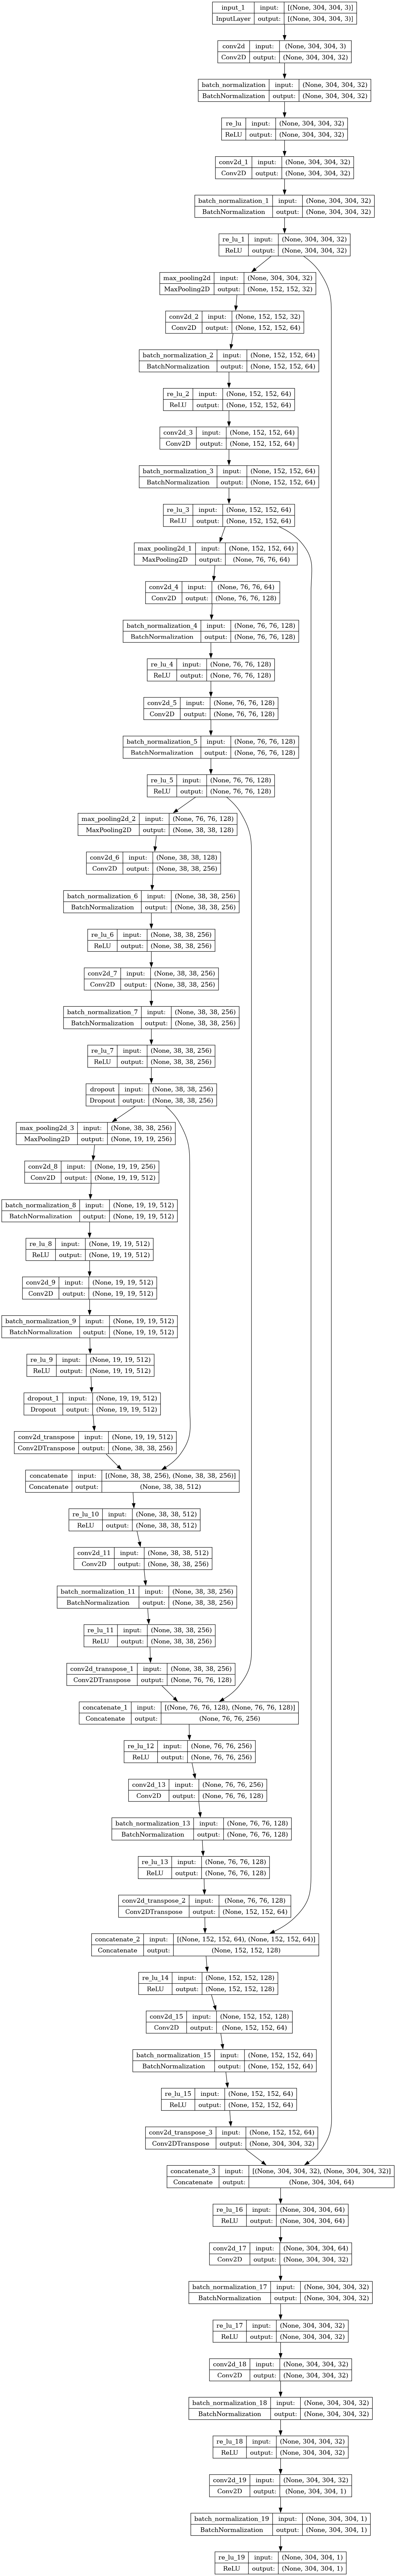

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(unet, show_shapes=True, show_layer_names=True)

# Compiling the model

In [16]:
unet.compile(optimizer = tf.keras.optimizers.Adam(), 
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), 
             metrics = ['accuracy'])

In [17]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                 factor=0.1,
                                                 patience=1,
                                                 min_lr=1e-6)
es = tf.keras.callbacks.EarlyStopping(patience=2)
EPOCHS = 50

# Training the Model

In [18]:
modelhist = unet.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[lr,es])

Epoch 1/50


2024-02-26 08:59:57.865174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708938009.285889     168 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 [==============================] - 101s 809ms/step - loss: 0.4979 - accuracy: 0.6121 - val_loss: 0.4739 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 58s 686ms/step - loss: 0.4580 - accuracy: 0.7105 - val_loss: 0.4430 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 58s 687ms/step - loss: 0.4292 - accuracy: 0.7546 - val_loss: 0.4154 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 58s 687ms/step - loss: 0.4028 - accuracy: 0.7890 - val_loss: 0.3901 - val_accuracy: 0.8072 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 58s 687ms/step - loss: 0.3779 - accuracy: 0.8193 - val_loss: 0.3664 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 58s 687ms/step - loss: 0.3547 - accuracy: 0.8441 - val_loss: 0.3440 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 58s 686ms/step - loss:

# Predicting the output for the testing data

In [19]:
y_pred = unet.predict(X_test)

10/10 [==============================] - 2s 164ms/step


# Plotting the learning curves

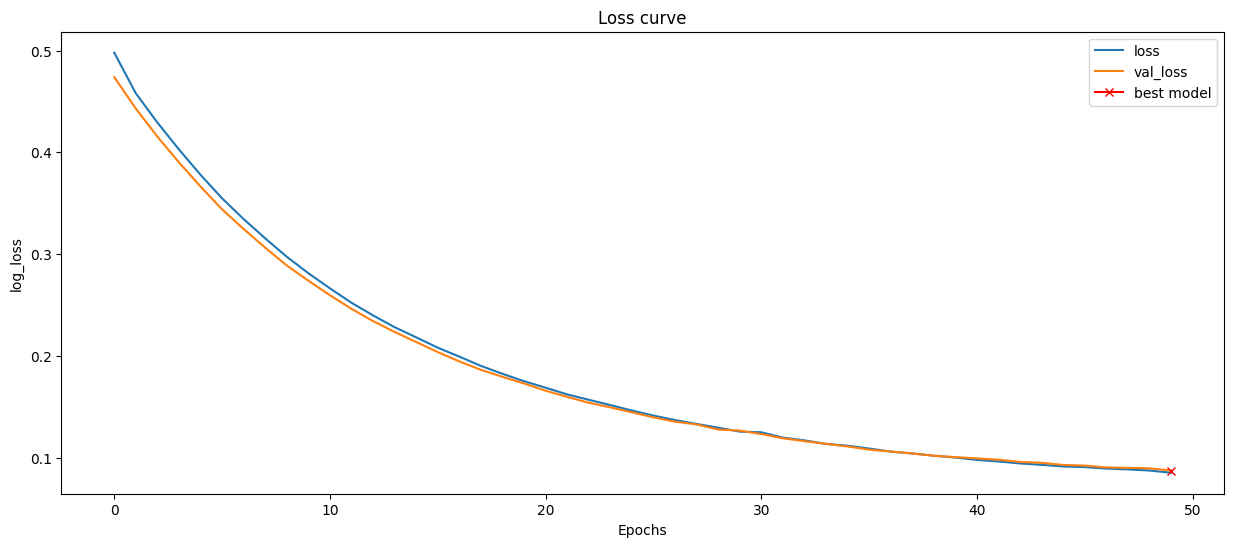

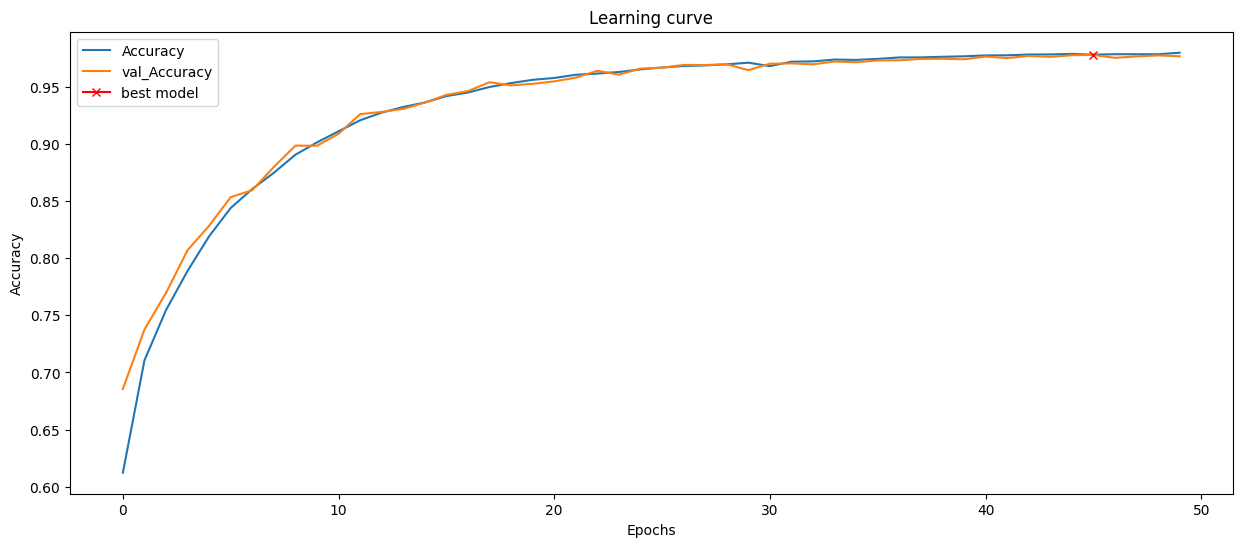

In [20]:
plt.figure(figsize = (15,6))
plt.title("Loss curve")
plt.plot(modelhist.history["loss"], label="loss")
plt.plot(modelhist.history["val_loss"], label="val_loss")
plt.plot(np.argmin(modelhist.history["val_loss"]), np.min(modelhist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(modelhist.history["accuracy"], label="Accuracy")
plt.plot(modelhist.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(modelhist.history["val_accuracy"]), np.max(modelhist.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        for k in range(len(y_pred[i][j])):
            y_pred[i][j][k][0] = np.floor(y_pred[i][j][k][0])

# Viewing the predictions made

In [21]:
def showimg(X_test, y_test, y_pred, ind):
    plt.imshow(X_test[ind])
    plt.show()
    plt.imshow(y_test[ind])
    plt.show()
    plt.imshow(y_pred[ind])
    plt.show()

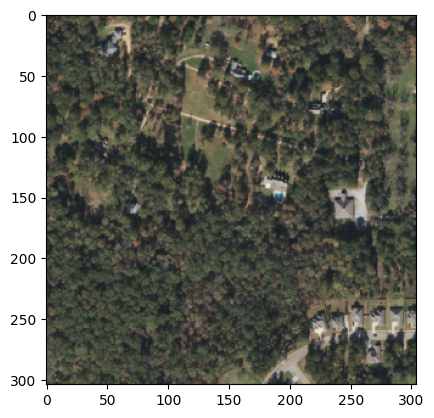

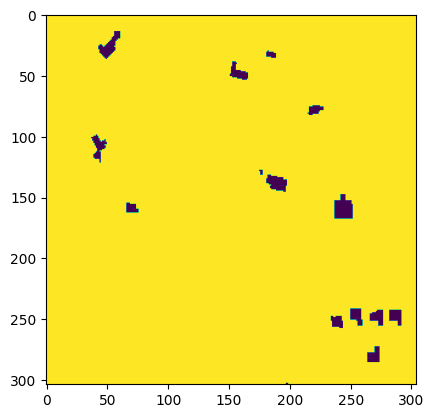

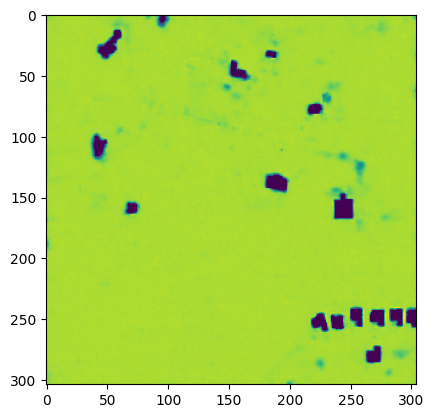

In [22]:
showimg(X_test, y_test, y_pred, 115)

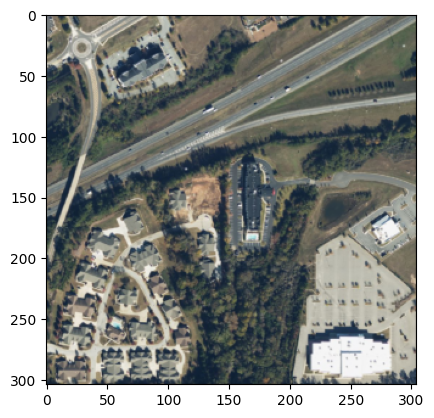

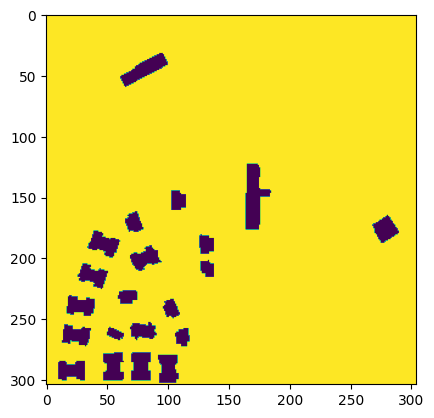

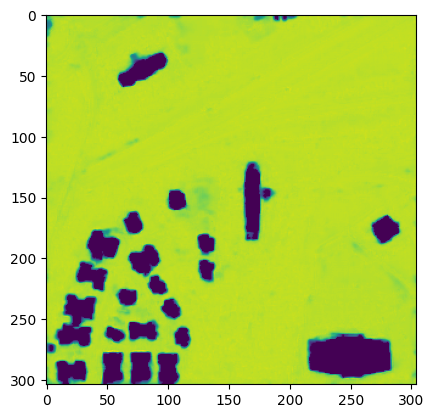

In [23]:
showimg(X_test, y_test, y_pred, 120)

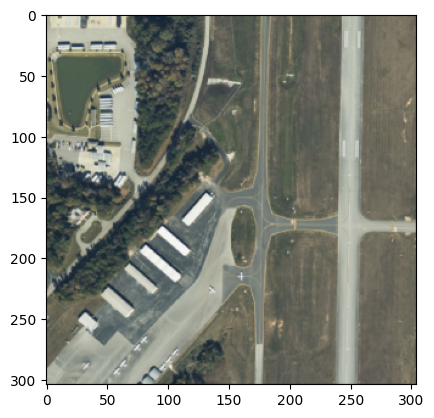

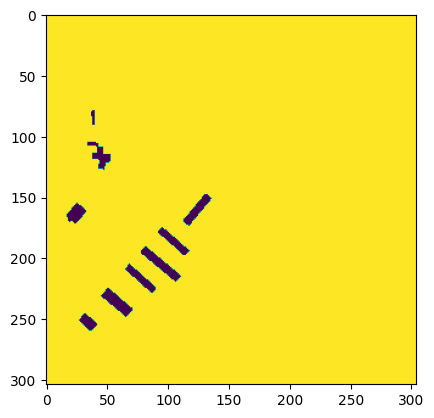

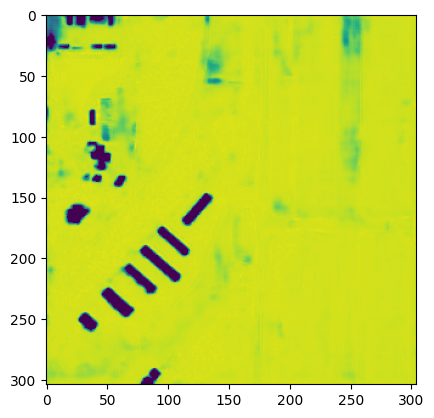

In [24]:
showimg(X_test, y_test, y_pred, 170)

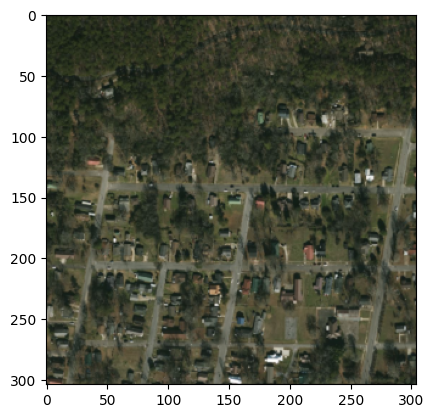

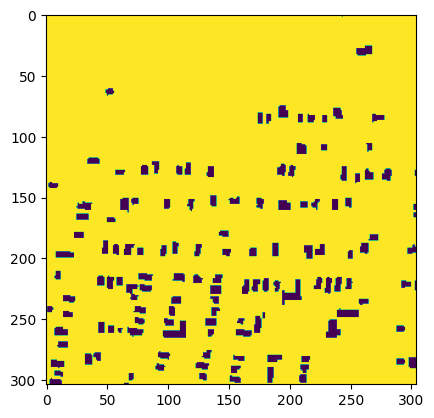

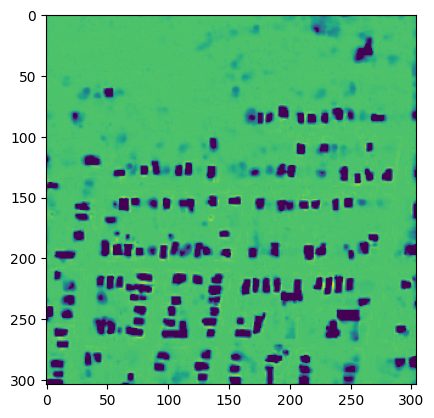

In [25]:
showimg(X_test, y_test, y_pred, 215)

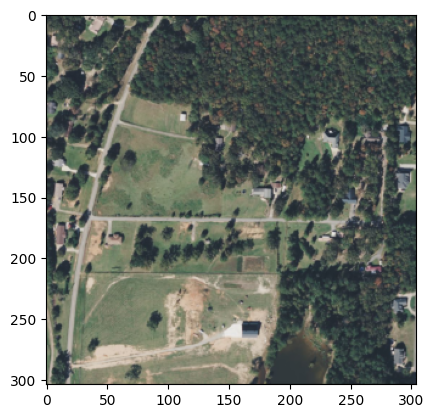

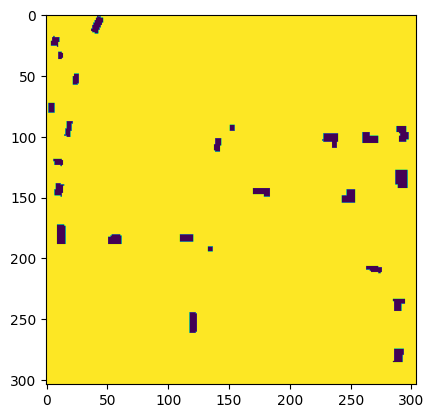

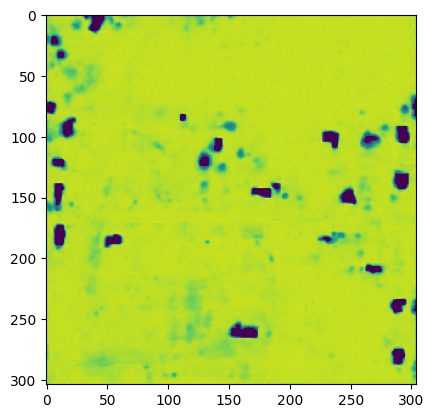

In [28]:
showimg(X_test, y_test, y_pred, 251)